In [8]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
data = pd.read_csv('D:/final_sem/single_prices_dataset.csv')

In [10]:
data.head()

,week_start_date,vegetable,location,month,week_of_year,fuel_price,price,temp,rainfall
0,1/5/2024,beet root,ampara,1,1,358,900.0,26.29,31.24
1,1/5/2024,beet root,anuradhapura,1,1,358,770.0,25.54,7.39
2,1/5/2024,beet root,badulla,1,1,358,NaN,22.29,17.19
3,1/5/2024,beet root,colombo,1,1,358,725.0,27.41,8.41
4,1/5/2024,beet root,dambulla,1,1,358,650.0,25.54,7.39


In [11]:
data.isnull().sum()

week_start_date      0
vegetable            0
location             0
month                0
week_of_year         0
fuel_price           0
price              600
temp                72
rainfall            72
dtype: int64

In [12]:
data['price'] = data.groupby(['week_start_date', 'vegetable'])['price'].transform(lambda x: x.fillna(x.mean()))
data['temp'] = data.groupby(['week_start_date'])['temp'].transform(lambda x: x.fillna(x.mean()))
data['rainfall'] = data.groupby(['week_start_date'])['rainfall'].transform(lambda x: x.fillna(x.mean()))

In [13]:
# Feature Engineering: Derived Features
data['sin_week'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['cos_week'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

In [14]:
festivals = [
    {"festival": "Sinhala and Tamil New Year", "start_date": "2024-04-08", "end_date": "2024-04-18"},
    {"festival": "Vesak", "start_date": "2024-05-17", "end_date": "2024-05-27"},
    {"festival": "Poson", "start_date": "2024-06-14", "end_date": "2024-06-24"},
    {"festival": "Ramazan", "start_date": "2024-03-10", "end_date": "2024-04-09"},
    {"festival": "Christmas", "start_date": "2024-12-20", "end_date": "2024-12-30"},
]

festival_df = pd.DataFrame(festivals)

data['week_start_date'] = pd.to_datetime(data['week_start_date'])
festival_df['start_date'] = pd.to_datetime(festival_df['start_date'])
festival_df['end_date'] = pd.to_datetime(festival_df['end_date'])

def asign_festivals(row):
      match = festival_df[(row["week_start_date"] >= festival_df["start_date"]) & (row["week_start_date"] <= festival_df["end_date"])]
      return 1 if not match.empty else 0

data['festival_season'] = data.apply(asign_festivals,axis=1)

In [15]:
# Remove outliers using IQR method
q1 = data['price'].quantile(0.25)
q3 = data['price'].quantile(0.75)
iqr = q3 - q1
ul = q3 + 1.5 * iqr
ll = q1 - 1.5 * iqr

data = data[((data.price >= ll) & (data.price <= ul))]

In [16]:
# One-hot encode categorical variables (vegetable and location)
def onehot_encode(data, column):
    data = data.copy()
    dummies = pd.get_dummies(data[column], prefix=column)
    dummies = dummies.astype(int)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    data.columns = data.columns.str.replace(' ', '_')
    return data

for column in ['vegetable', 'location']:
    data = onehot_encode(data, column)

In [17]:
data.head()

,week_start_date,month,week_of_year,fuel_price,price,temp,rainfall,sin_week,cos_week,festival_season,...,location_dambulla,location_galle,location_gampaha,location_jaffna,location_kaluthara,location_kandy,location_meegoda,location_monaragala,location_nuwaraeliya,location_ratnapura
3,2024-01-05,1,1,358,725.0,27.41,8.41,0.120537,0.992709,0,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-05,1,1,358,650.0,25.54,7.39,0.120537,0.992709,0,...,1,0,0,0,0,0,0,0,0,0
7,2024-01-05,1,1,358,605.0,26.41,2.26,0.120537,0.992709,0,...,0,0,0,1,0,0,0,0,0,0
9,2024-01-05,1,1,358,725.0,22.29,18.47,0.120537,0.992709,0,...,0,0,0,0,0,1,0,0,0,0
12,2024-01-05,1,1,358,670.0,15.29,11.69,0.120537,0.992709,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
encoded_columns = [col for col in data.columns if col.startswith(('vegetable_','location_'))]
encoded_columns

import pickle

with open('encoded_columns.pkl', 'wb') as f:
   pickle.dump(encoded_columns,f)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X = data.drop(columns=['week_start_date','price','temp'])
Y = data['price']


# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=54545
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import pickle

with open('scaler.pkl','wb') as f:
  pickle.dump(scaler,f)

In [20]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Ridge' : Ridge(alpha=1.0),
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=0),
    'XGBoost': xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6),
    'LightGBM': lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6)
}

In [21]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return y_pred, {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

Evaluating Linear Regression for Price...


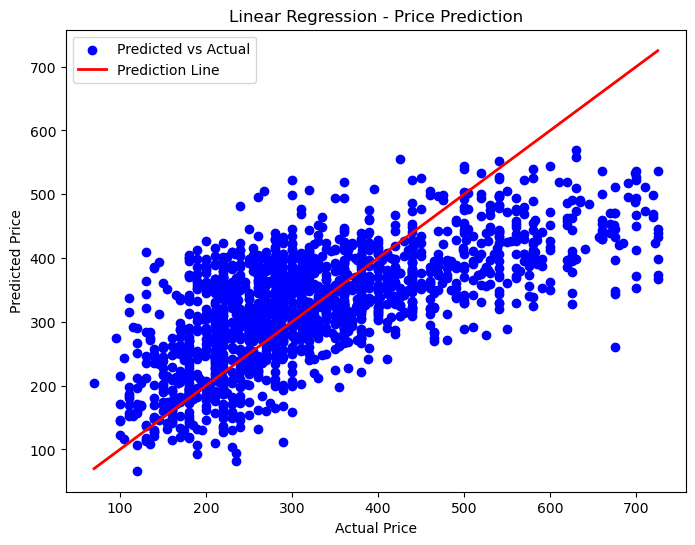

Metrics for Linear Regression (Price):
{'RMSE': 101.82705040914443, 'MAE': 79.58417217891004, 'R²': 0.43234856125334375}
Evaluating Random Forest for Price...


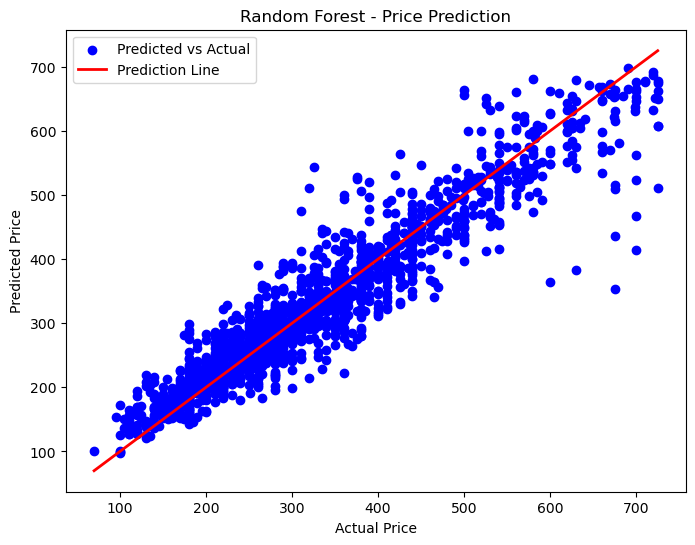

Metrics for Random Forest (Price):
{'RMSE': 44.989996217699606, 'MAE': 31.95019834869835, 'R²': 0.8891878634593724}
Evaluating Decision Tree for Price...


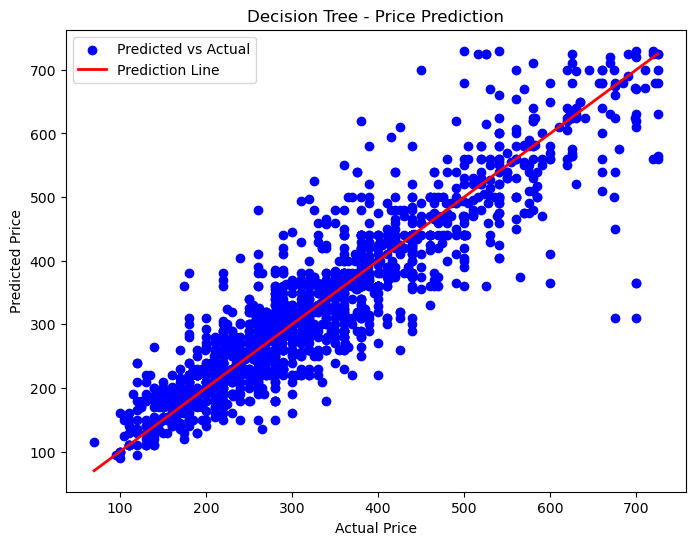

Metrics for Decision Tree (Price):
{'RMSE': 57.63081088834904, 'MAE': 39.63645113645114, 'R²': 0.8181702775506038}
Evaluating SVR for Price...


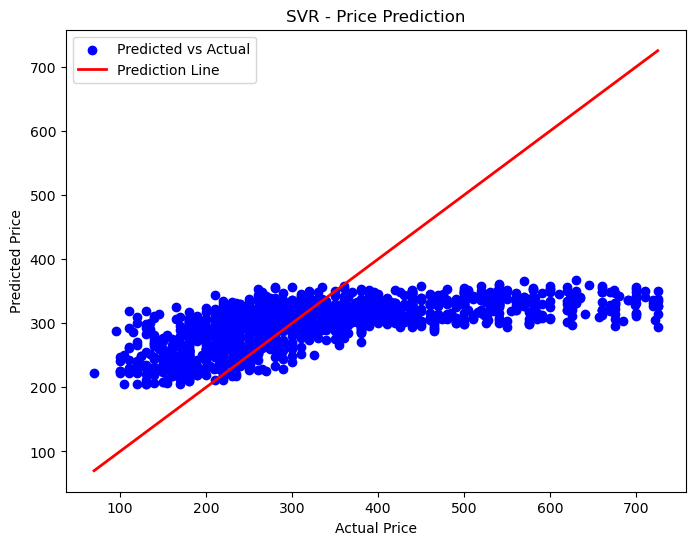

Metrics for SVR (Price):
{'RMSE': 119.689875875353, 'MAE': 87.58077684417403, 'R²': 0.2157216104911871}
Evaluating Ridge for Price...


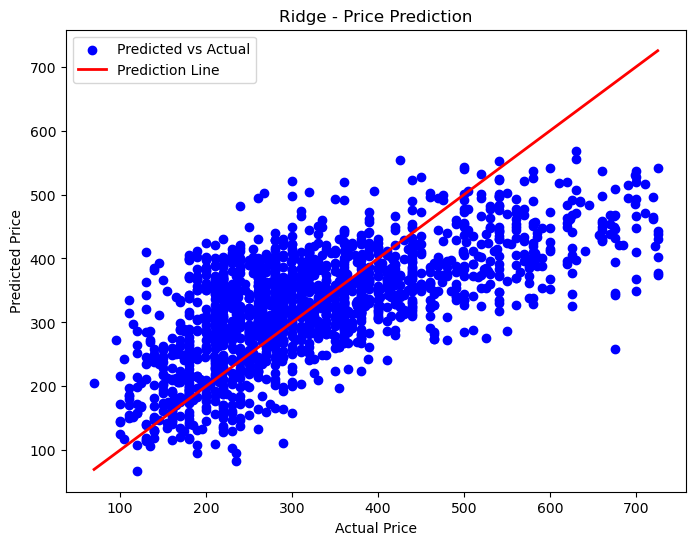

Metrics for Ridge (Price):
{'RMSE': 101.83518264593508, 'MAE': 79.54422125026207, 'R²': 0.43225788868193515}
Evaluating CatBoost for Price...


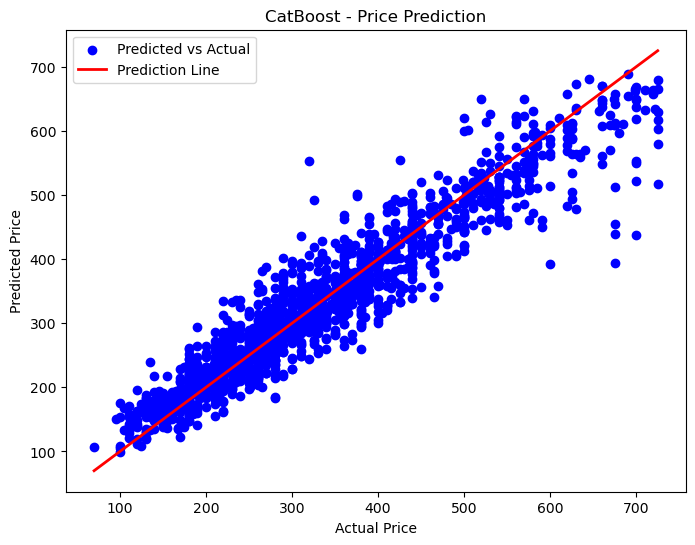

Metrics for CatBoost (Price):
{'RMSE': 43.45983279324871, 'MAE': 31.541219501920825, 'R²': 0.8965973861040546}
Evaluating XGBoost for Price...


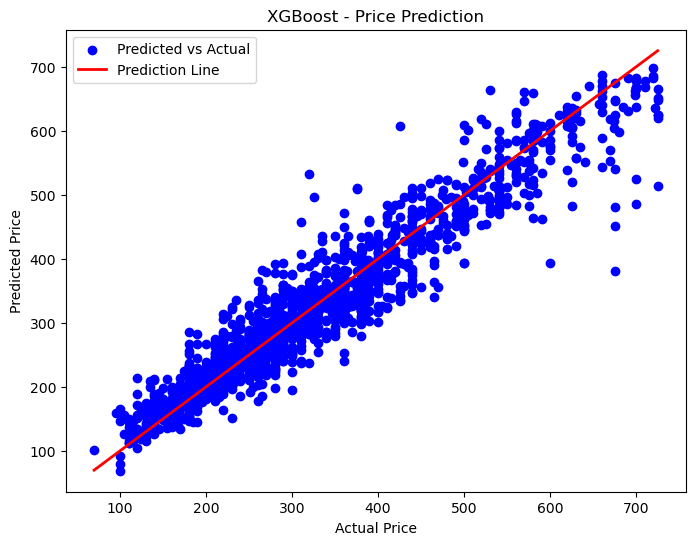

Metrics for XGBoost (Price):
{'RMSE': 41.28345651028292, 'MAE': 29.62921108863034, 'R²': 0.9066944409850182}
Evaluating LightGBM for Price...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 6660, number of used features: 33
[LightGBM] [Info] Start training from score 328.989423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

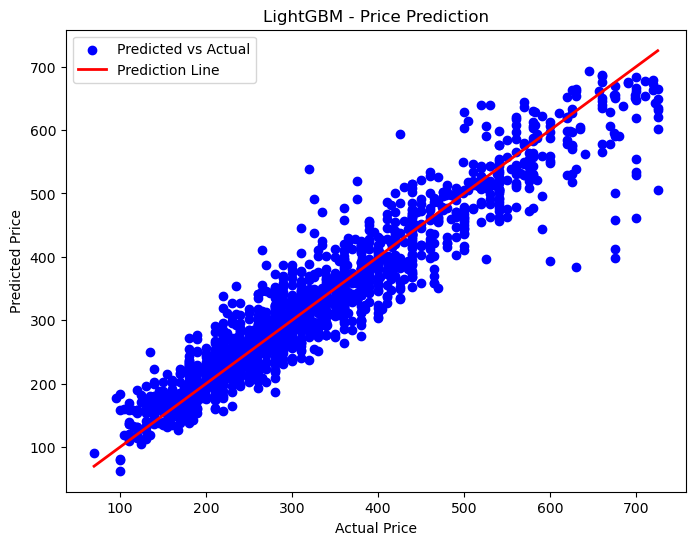

Metrics for LightGBM (Price):
{'RMSE': 43.112749824357444, 'MAE': 30.90507289028551, 'R²': 0.8982423981872895}


In [22]:
for model_name in models.keys():
    print(f"Evaluating {model_name} for Price...")
    model = models[model_name]
    Y_pred, metrics = evaluate_model(model, X_train_scaled, X_test_scaled, Y_train, Y_test)

    # Scatter plot for min price predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', lw=2, label="Prediction Line")
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Price Prediction')
    plt.legend()
    plt.show()

    # Print the model's evaluation metrics for min and max price
    print(f"Metrics for {model_name} (Price):")
    print(metrics)
    print("="*50)

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import randint,uniform
import xgboost as xgb

# Initialize model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter space
param_dist = {
    'learning_rate': uniform(0.001,0.3),
    'n_estimators': randint(50,1000),  
    'max_depth': randint(3, 12),       
    'min_child_weight': randint(1, 10), 
    'gamma':uniform(0,1),
}

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

In [25]:
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_root_mean_squared_error',
    cv=rkf,
    verbose=2,
    random_state=42,
    n_jobs=-1, )
random_search.fit(X_train_scaled, Y_train)
print("Best parameters found: ", random_search.best_params_)
best_param = random_search.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Best parameters found:  {'gamma': 0.26520236768172545, 'learning_rate': 0.07419689301372508, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 414}


In [26]:
import xgboost as xgb
final_model = xgb.XGBRegressor(**best_param)
y_pred_final, metrics_best_param = evaluate_model(final_model, X_train_scaled, X_test_scaled, Y_train, Y_test)
metrics_best_param

{'RMSE': 40.917566010325885,
 'MAE': 29.606869779942595,
 'R²': 0.9083410245208292}

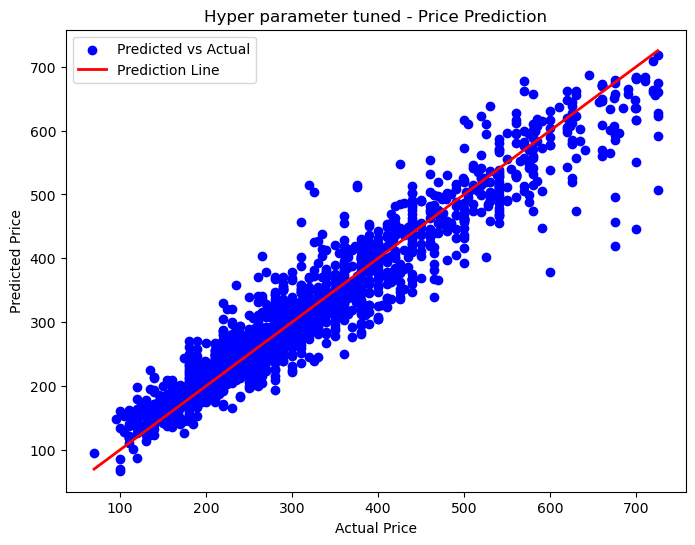

In [27]:
    # Scatter plot for min price predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test, y_pred_final, color='blue', label='Predicted vs Actual')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', lw=2, label="Prediction Line")
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Hyper parameter tuned - Price Prediction')
    plt.legend()
    plt.show()

In [28]:
comparison = pd.DataFrame({
    "Actual":Y_test,
    "Predicted":y_pred_final
})

comparison.head(10)

,Actual,Predicted
24,530.0,638.873291
7686,190.0,206.779648
3999,250.0,205.972443
3547,360.0,429.090668
5549,260.0,263.971191
2459,250.0,272.951233
8339,425.0,339.486908
1881,470.0,365.286255
8039,435.0,386.314880
6661,300.0,324.598297


In [24]:
with open('final_model.pkl', 'wb') as f:
   pickle.dump(final_model,f)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from datetime import timedelta

with open('encoded_columns.pkl', 'rb') as f:
    encoded_columns = pickle.load(f)

with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)


def predict_price(user_input, model,encoded_columns, scaler):
    
    date = user_input['current_date']
    vegetables = user_input['vegetables']
    location = user_input['location']
    fuel_price = user_input['fuel_price']
    rainfall = user_input['rainfall']
    festival = user_input['festival']
    pred_type = user_input['pred_type']

     # Parse the input date
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    next_week_date_obj = date_obj + timedelta(weeks=1)
    month = next_week_date_obj.month
    next_week = next_week_date_obj.isocalendar()[1]

    single_week_start = next_week_date_obj - timedelta(days=date_obj.weekday())
    single_week_end = single_week_start + timedelta(days=6)

    results = {
            'location':location,
            'week_start':single_week_start.strftime("%Y-%m-%d"),
            'week_end':single_week_end.strftime("%Y-%m-%d"),
            'predictions':[]}
    
    # retreving the cos and and sin values to provide as inputs 
    sin_week = np.sin(2 * np.pi * next_week / 52)
    cos_week = np.cos(2 * np.pi * next_week / 52)
    
   #checking the vegetable param is coming as a list,if so it assign as a list  
    if isinstance(vegetables, str):
        vegetables = [vegetables]

    for vegetable in vegetables:
        # creating the input data as a dataframe
        input_data = pd.DataFrame({
            'month': [month],
            'week_of_year': [next_week], 
            'fuel_price': [fuel_price],
            'rainfall': [rainfall],
            'sin_week': [sin_week],
            'cos_week': [cos_week],
            'festival_season' : [festival]
        })
        
        #getting encoded columns from the arguments 
        all_vegetables = [col for col in encoded_columns if col.startswith('vegetable_')]
        all_locations = [col for col in encoded_columns if col.startswith('location_')]

        #filling the relavant value as 1 and others 0 if the column name mathces
        for veg in all_vegetables:
            input_data[veg] = 1 if f'vegetable_{vegetable}' == veg else 0
        
        for loc in all_locations:
            input_data[loc] = 1 if f'location_{location}' == loc else 0
        
        #if any missing column which is not filled it also be marked as 0
        missing_columns = set(encoded_columns) - set(input_data.columns)
        for col in missing_columns:
            input_data[col] = 0

        if pred_type == 'week':
            #scaling all the inputs as done while trainig the model
            input_scaled = scaler.transform(input_data) 
            predicted_price = model.predict(input_scaled)[0]
            
            results['predictions'].append(
                {'vegetable': vegetable,
                'price':predicted_price
              })
            
        elif pred_type == '4week':
            results = {'vegetable': vegetable,'location': location,'predictions': []}
                    
            for i in range(1,5):   
                new_date_obj = date_obj + timedelta(weeks=i)
            
                new_month = new_date_obj.month
                new_year = new_date_obj.year
                
                # Calculate sinusoidal transformations
                new_week_of_year = new_date_obj.isocalendar()[1]
                new_sin_week = np.sin(2 * np.pi * new_week_of_year / 52)
                new_cos_week = np.cos(2 * np.pi * new_week_of_year / 52)
            
                # Calculate the start and end dates of the week
            
                week_start = new_date_obj - timedelta(days=new_date_obj.weekday())
                week_end = week_start + timedelta(days=6)
        
                # Update the input data
                input_data['month'] = new_month
                input_data['week_of_year'] = new_week_of_year
                input_data['sin_week'] = new_sin_week
                input_data['cos_week'] = new_cos_week
            
                # Scale the updated data
                input_scaled = scaler.transform(input_data)
                
                # Predict prices
                predicted_price = model.predict(input_scaled)[0]
                
                
                #Append results
                results['predictions'].append({
                'week_start': week_start.strftime("%Y-%m-%d"),
                'week_end': week_end.strftime("%Y-%m-%d"),
                'price':predicted_price,
                  })
                
    return results

In [39]:
# Define inputs
user_input = {
'current_date' : '2024-12-23',
'vegetables' : ['pumpkin'],
'location' : 'colombo',
'fuel_price' : 316,
'rainfall' : 0.12,
'pred_type':'week',
'festival':0   
}

# Predict prices
predicted_prices = predict_price(user_input,final_model,encoded_columns,scaler)

print("Predicted Prices:")
print(predicted_prices)


Predicted Prices:
{'location': 'colombo', 'week_start': '2024-12-30', 'week_end': '2025-01-05', 'predictions': [{'vegetable': 'pumpkin', 'price': 216.62329}]}
